# Price Data Cleaning and Validation

This notebook cleans and validates the price data downloaded from Alpha Vantage. It performs various data quality checks including:
- Date range validation against FINRA data
- Missing data analysis
- Data quality checks for prices and volumes
- Identification of tickers with incomplete time series

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Data Loading and Initial Exploration

In [2]:
# Set data directory paths
DATA_DIR = Path("../data")
FINRA_DIR = DATA_DIR / "finra_clean"
PRICE_DIR = DATA_DIR / "prices"

print(f"FINRA data directory: {FINRA_DIR}")
print(f"Price data directory: {PRICE_DIR}")
print(f"FINRA directory exists: {FINRA_DIR.exists()}")
print(f"Price directory exists: {PRICE_DIR.exists()}")

FINRA data directory: ../data/finra_clean
Price data directory: ../data/prices
FINRA directory exists: True
Price directory exists: True


In [3]:
# List available price data files
price_files = list(PRICE_DIR.glob("*.parquet"))
failed_files = list(PRICE_DIR.glob("failed_symbols_*.csv"))
sample_files = list(PRICE_DIR.glob("*.xlsx"))

print("Available price data files:")
for file in price_files:
    print(f"  - {file.name}")
    
print("\nFailed symbols files:")
for file in failed_files:
    print(f"  - {file.name}")
    
print("\nSample files:")
for file in sample_files:
    print(f"  - {file.name}")

Available price data files:
  - price_data_multiindex_20250904_113138.parquet
  - price_data_cleaned_20250918_105548.parquet

Failed symbols files:
  - failed_symbols_20250904_113138.csv

Sample files:
  - price_data_sample_20250904_113138.xlsx


## Load Price Data

In [4]:
# Load the main price data
if price_files:
    price_file = price_files[0]  # Use the first (and likely only) parquet file
    print(f"Loading price data from: {price_file.name}")
    
    price_data = pd.read_parquet(price_file)
    
    print(f"Price data shape: {price_data.shape}")
    print(f"Price data columns: {list(price_data.columns)}")
    print(f"Price data index: {price_data.index.names}")
    print(f"Price data dtypes:\n{price_data.dtypes}")
else:
    print("No price data parquet files found!")
    price_data = pd.DataFrame()

Loading price data from: price_data_multiindex_20250904_113138.parquet
Price data shape: (6499, 46544)
Price data columns: [('A', '1. open'), ('A', '2. high'), ('A', '3. low'), ('A', '4. close'), ('A', '5. adjusted close'), ('A', '6. volume'), ('A', '7. dividend amount'), ('A', '8. split coefficient'), ('KMTUF', '1. open'), ('KMTUF', '2. high'), ('KMTUF', '3. low'), ('KMTUF', '4. close'), ('KMTUF', '5. adjusted close'), ('KMTUF', '6. volume'), ('KMTUF', '7. dividend amount'), ('KMTUF', '8. split coefficient'), ('KNYJF', '1. open'), ('KNYJF', '2. high'), ('KNYJF', '3. low'), ('KNYJF', '4. close'), ('KNYJF', '5. adjusted close'), ('KNYJF', '6. volume'), ('KNYJF', '7. dividend amount'), ('KNYJF', '8. split coefficient'), ('KNX', '1. open'), ('KNX', '2. high'), ('KNX', '3. low'), ('KNX', '4. close'), ('KNX', '5. adjusted close'), ('KNX', '6. volume'), ('KNX', '7. dividend amount'), ('KNX', '8. split coefficient'), ('KNSL', '1. open'), ('KNSL', '2. high'), ('KNSL', '3. low'), ('KNSL', '4. c

In [5]:
# Examine the structure of the price data
if not price_data.empty:
    print("First few rows of price data:")
    print(price_data.head())
    
    # Check if the INDEX is MultiIndex or if COLUMNS are MultiIndex
    print(f"\nIndex type: {type(price_data.index)}")
    print(f"Column type: {type(price_data.columns)}")
    
    if isinstance(price_data.columns, pd.MultiIndex):
        # Symbols are in columns (MultiIndex)
        unique_symbols = len(price_data.columns.get_level_values(0).unique())
        print(f"Number of unique symbols: {unique_symbols}")
        print(f"Date range: {price_data.index.min()} to {price_data.index.max()}")
        print(f"Symbols (first 10): {list(price_data.columns.get_level_values(0).unique()[:10])}")
        print(f"Total unique dates: {len(price_data.index)}")
        print(f"Column structure: {price_data.columns.names}")
    elif isinstance(price_data.index, pd.MultiIndex):
        # Traditional MultiIndex on rows (symbol, date)
        symbols = price_data.index.get_level_values(0).unique()
        dates = price_data.index.get_level_values(1).unique()
        print(f"Number of unique symbols: {len(symbols)}")
        print(f"Date range: {dates.min()} to {dates.max()}")
        print(f"Symbols (first 10): {list(symbols[:10])}")
        print(f"Total unique dates: {len(dates)}")
    else:
        # Single index (likely dates) with symbols as columns
        print(f"Single index name: {price_data.index.name}")
        print(f"Number of columns: {len(price_data.columns)}")
        print(f"Date range: {price_data.index.min()} to {price_data.index.max()}")
        print(f"Total unique dates: {len(price_data.index)}")

First few rows of price data:
                 A                                                      \
           1. open 2. high 3. low 4. close 5. adjusted close 6. volume   
1999-11-01     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-02     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-03     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-04     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-05     NaN     NaN    NaN      NaN               NaN       NaN   

                                                     KMTUF          ...  \
           7. dividend amount 8. split coefficient 1. open 2. high  ...   
1999-11-01                NaN                  NaN     NaN     NaN  ...   
1999-11-02                NaN                  NaN     NaN     NaN  ...   
1999-11-03                NaN                  NaN     NaN     NaN  ...   
1999-11-04                NaN                  NaN     NaN     NaN  ...   
1

## Load FINRA Data for Date Validation

In [6]:
# Load FINRA data to determine the valid date range
csv_files = sorted(FINRA_DIR.glob("shrt*_clean.csv"))
print(f"Found {len(csv_files)} FINRA files")

if csv_files:
    print(f"First FINRA file: {csv_files[0].name}")
    print(f"Last FINRA file: {csv_files[-1].name}")
    
    # Extract dates from filenames
    finra_dates = []
    for file in csv_files:
        date_match = re.search(r'shrt(\d{8})_clean', file.name)
        if date_match:
            date_str = date_match.group(1)
            finra_date = pd.to_datetime(date_str, format='%Y%m%d')
            finra_dates.append(finra_date)
    
    finra_dates = sorted(finra_dates)
    min_finra_date = min(finra_dates)
    max_finra_date = max(finra_dates)
    
    print(f"\nFINRA date range:")
    print(f"  Minimum date: {min_finra_date.strftime('%Y-%m-%d')}")
    print(f"  Maximum date: {max_finra_date.strftime('%Y-%m-%d')}")
    print(f"  Total FINRA reporting periods: {len(finra_dates)}")
else:
    print("No FINRA files found!")
    min_finra_date = None
    max_finra_date = None

Found 182 FINRA files
First FINRA file: shrt20171229_clean.csv
Last FINRA file: shrt20250715_clean.csv

FINRA date range:
  Minimum date: 2017-12-29
  Maximum date: 2025-07-15
  Total FINRA reporting periods: 182


In [7]:
# Load a sample FINRA file to understand the symbol universe
if csv_files:
    sample_finra = pd.read_csv(csv_files[0])
    print(f"Sample FINRA data shape: {sample_finra.shape}")
    print(f"FINRA columns: {list(sample_finra.columns)}")
    
    # Get unique symbols from FINRA data
    finra_symbols = sample_finra['symbolCode'].unique()
    print(f"Number of symbols in FINRA data: {len(finra_symbols)}")
    print(f"Sample FINRA symbols: {list(finra_symbols[:10])}")
    
    print(f"\nSample FINRA data:")
    print(sample_finra.head())

Sample FINRA data shape: (15495, 14)
FINRA columns: ['accountingYearMonthNumber', 'symbolCode', 'issueName', 'issuerServicesGroupExchangeCode', 'marketClassCode', 'currentShortPositionQuantity', 'previousShortPositionQuantity', 'stockSplitFlag', 'averageDailyVolumeQuantity', 'daysToCoverQuantity', 'revisionFlag', 'changePercent', 'changePreviousNumber', 'settlementDate']
Number of symbols in FINRA data: 15495
Sample FINRA symbols: ['A', 'AA', 'AAALF', 'AAAP', 'AABA', 'AABVF', 'AAC', 'AACAF', 'AACAY', 'AACEY']

Sample FINRA data:
   accountingYearMonthNumber symbolCode                       issueName  \
0                   20171229          A            Agilent Technologies   
1                   20171229         AA               Alcoa Corporation   
2                   20171229      AAALF              Aareal Bank AG AKT   
3                   20171229       AAAP  Advanced Accelerator Applicati   
4                   20171229       AABA       Altaba, Inc. Common Stock   

  issuerServic

## Date Range Validation

In [8]:
# Validate price data date range against FINRA data
if not price_data.empty and min_finra_date is not None:
    # Get price data date range (dates are in the index)
    price_dates = price_data.index
    
    min_price_date = price_dates.min()
    max_price_date = price_dates.max()
    
    print("Date Range Comparison:")
    print(f"FINRA data range: {min_finra_date.strftime('%Y-%m-%d')} to {max_finra_date.strftime('%Y-%m-%d')}")
    print(f"Price data range: {min_price_date.strftime('%Y-%m-%d')} to {max_price_date.strftime('%Y-%m-%d')}")
    
    # Check for dates outside FINRA range
    dates_before_finra = (price_dates < min_finra_date).sum()
    dates_after_finra = (price_dates > max_finra_date).sum()
    
    print(f"\nDate validation:")
    print(f"  Price dates before FINRA start: {dates_before_finra:,}")
    print(f"  Price dates after FINRA end: {dates_after_finra:,}")
    
    if dates_before_finra > 0 or dates_after_finra > 0:
        print(f"  -> Dates outside FINRA range found - will need filtering")
    else:
        print(f"  -> All price dates are within FINRA range")

Date Range Comparison:
FINRA data range: 2017-12-29 to 2025-07-15
Price data range: 1999-11-01 to 2025-09-03

Date validation:
  Price dates before FINRA start: 4,570
  Price dates after FINRA end: 35
  -> Dates outside FINRA range found - will need filtering


In [31]:
# Analyze price data date range against FINRA data (but preserve historical data)
if not price_data.empty and min_finra_date is not None:
    initial_rows = len(price_data)
    
    # Analyze the date overlap without filtering yet
    price_dates = price_data.index
    dates_before_finra = (price_dates < min_finra_date).sum()
    dates_after_finra = (price_dates > max_finra_date).sum()
    dates_within_finra = len(price_dates) - dates_before_finra - dates_after_finra
    
    print(f"Date range analysis:")
    print(f"  Total price data rows: {initial_rows:,}")
    print(f"  Dates before FINRA start: {dates_before_finra:,}")
    print(f"  Dates within FINRA period: {dates_within_finra:,}")
    print(f"  Dates after FINRA end: {dates_after_finra:,}")
    
    # Keep all historical data for feature engineering
    # We'll filter to FINRA period only when creating final analysis datasets
    print(f"\nPreserving all historical data for feature engineering")
    print(f"Historical data available from: {price_dates.min().strftime('%Y-%m-%d')}")
    print(f"FINRA analysis period: {min_finra_date.strftime('%Y-%m-%d')} to {max_finra_date.strftime('%Y-%m-%d')}")
    
    # Calculate how much historical data we have before FINRA period
    historical_period_days = (min_finra_date - price_dates.min()).days
    historical_period_years = historical_period_days / 365.25
    
    print(f"Historical buffer: {historical_period_days} days ({historical_period_years:.1f} years)")
    print(f"This allows for moving averages up to {historical_period_days} days")
    
    # Store the FINRA period mask for later use
    finra_period_mask = (price_data.index >= min_finra_date) & (price_data.index <= max_finra_date)
    
    print(f"\nKeeping full price dataset shape: {price_data.shape}")
    print(f"FINRA period subset would be: {finra_period_mask.sum():,} dates")

Date range analysis:
  Total price data rows: 6,499
  Dates before FINRA start: 4,570
  Dates within FINRA period: 1,894
  Dates after FINRA end: 35

Preserving all historical data for feature engineering
Historical data available from: 1999-11-01
FINRA analysis period: 2017-12-29 to 2025-07-15
Historical buffer: 6633 days (18.2 years)
This allows for moving averages up to 6633 days

Keeping full price dataset shape: (6499, 46552)
FINRA period subset would be: 1,894 dates


In [30]:
# Reload the original price data (unfiltered) to preserve historical data
print("=== RELOADING ORIGINAL PRICE DATA ===\n")

if price_files:
    price_file = price_files[0]
    print(f"Reloading original price data from: {price_file.name}")
    
    # Reload the original unfiltered data
    price_data_original = pd.read_parquet(price_file)
    
    # Integrate any retry data that was successfully downloaded
    if 'retry_data' in locals() and len(retry_data) > 0:
        print(f"Re-integrating {len(retry_data)} successfully downloaded symbols...")
        
        for symbol, symbol_df in retry_data.items():
            if isinstance(price_data_original.columns, pd.MultiIndex):
                new_columns = []
                for col in symbol_df.columns:
                    new_columns.append((symbol, col))
                
                symbol_df_formatted = symbol_df.copy()
                symbol_df_formatted.columns = pd.MultiIndex.from_tuples(new_columns)
                symbol_df_aligned = symbol_df_formatted.reindex(price_data_original.index)
                
                for col in symbol_df_aligned.columns:
                    if col not in price_data_original.columns:
                        price_data_original[col] = symbol_df_aligned[col]
                        print(f"  Re-added column: {col}")
    
    # Update the global price_data variable
    price_data = price_data_original
    
    print(f"\nReloaded price data shape: {price_data.shape}")
    print(f"Date range: {price_data.index.min()} to {price_data.index.max()}")
    
    if isinstance(price_data.columns, pd.MultiIndex):
        symbols_count = len(price_data.columns.get_level_values(0).unique())
        print(f"Total symbols: {symbols_count}")
    
else:
    print("No price files found to reload")

=== RELOADING ORIGINAL PRICE DATA ===

Reloading original price data from: price_data_multiindex_20250904_113138.parquet
Re-integrating 1 successfully downloaded symbols...
  Re-added column: ('FLC', 'open')
  Re-added column: ('FLC', 'high')
  Re-added column: ('FLC', 'low')
  Re-added column: ('FLC', 'close')
  Re-added column: ('FLC', 'adjusted_close')
  Re-added column: ('FLC', 'volume')
  Re-added column: ('FLC', 'dividend_amount')
  Re-added column: ('FLC', 'split_coefficient')

Reloaded price data shape: (6499, 46552)
Date range: 1999-11-01 00:00:00 to 2025-09-03 00:00:00
Total symbols: 5819


## Missing Data Analysis

In [10]:
# Analyze missing data patterns for each ticker
if not price_data.empty and isinstance(price_data.columns, pd.MultiIndex):
    symbols_in_price_data = price_data.columns.get_level_values(0).unique()
    print(f"Number of symbols with price data: {len(symbols_in_price_data)}")
    
    # Use actual trading days from the dataset instead of just weekdays
    # This accounts for market holidays and other market closures
    actual_trading_days = len(price_data.index.unique())
    print(f"Actual trading days in dataset: {actual_trading_days}")
    
    # For comparison, also show weekdays calculation
    all_price_dates = pd.date_range(
        start=price_data.index.min(),
        end=price_data.index.max(),
        freq='D'
    )
    weekday_dates = all_price_dates[all_price_dates.weekday < 5]
    print(f"Weekdays in date range (including holidays): {len(weekday_dates)}")
    print(f"Market holidays/closures: {len(weekday_dates) - actual_trading_days}")
    
    # Analyze data completeness for each symbol using actual trading days
    symbol_completeness = []
    
    for symbol in symbols_in_price_data:
        # Get all columns for this symbol (OHLCV data)
        symbol_columns = [col for col in price_data.columns if col[0] == symbol]
        if symbol_columns:
            # Use the close price column to check data availability
            close_col = None
            for col in symbol_columns:
                if 'close' in str(col[1]).lower():
                    close_col = col
                    break
            
            if close_col is not None:
                symbol_data = price_data[close_col].dropna()
                available_dates = len(symbol_data)
                # Use actual trading days as the baseline for 100% completeness
                completeness_pct = (available_dates / actual_trading_days) * 100
                
                symbol_completeness.append({
                    'symbol': symbol,
                    'available_days': available_dates,
                    'expected_days': actual_trading_days,
                    'completeness_pct': completeness_pct,
                    'missing_days': actual_trading_days - available_dates
                })
    
    completeness_df = pd.DataFrame(symbol_completeness)
    completeness_df = completeness_df.sort_values('completeness_pct', ascending=False)
    
    print(f"\nData completeness summary (using actual trading days):")
    print(f"  Mean completeness: {completeness_df['completeness_pct'].mean():.2f}%")
    print(f"  Median completeness: {completeness_df['completeness_pct'].median():.2f}%")
    print(f"  Min completeness: {completeness_df['completeness_pct'].min():.2f}%")
    print(f"  Max completeness: {completeness_df['completeness_pct'].max():.2f}%")

Number of symbols with price data: 5818
Actual trading days in dataset: 1894
Weekdays in date range (including holidays): 1968
Market holidays/closures: 74

Data completeness summary (using actual trading days):
  Mean completeness: 96.94%
  Median completeness: 100.00%
  Min completeness: 0.00%
  Max completeness: 100.00%


In [11]:
# Show symbols with poor data completeness
if 'completeness_df' in locals():
    print("Symbols with less than 90% data completeness:")
    poor_completeness = completeness_df[completeness_df['completeness_pct'] < 90.0]
    print(f"Number of symbols with <90% completeness: {len(poor_completeness)}")
    
    if len(poor_completeness) > 0:
        print("\nTop 20 symbols with lowest completeness:")
        print(poor_completeness.head(20).to_string(index=False))
    
    print(f"\nSymbols with 100% data completeness: {len(completeness_df[completeness_df['completeness_pct'] == 100.0])}")
    print(f"Symbols with 95%+ data completeness: {len(completeness_df[completeness_df['completeness_pct'] >= 95.0])}")

Symbols with less than 90% data completeness:
Number of symbols with <90% completeness: 525

Top 20 symbols with lowest completeness:
symbol  available_days  expected_days  completeness_pct  missing_days
 CLNXF            1704           1894         89.968321           190
 HLKHF            1696           1894         89.545935           198
 HRSEF            1689           1894         89.176346           205
 COBJF            1687           1894         89.070750           207
 VTXPF            1686           1894         89.017951           208
 LUKOY            1685           1894         88.965153           209
 XYIGF            1683           1894         88.859556           211
 SOOBF            1683           1894         88.859556           211
 KBRLF            1678           1894         88.595565           216
 SOLLF            1676           1894         88.489968           218
 BCCLF            1675           1894         88.437170           219
  IICN            1669    

In [12]:
# Investigate the trading days calculation issue
print("=== INVESTIGATING TRADING DAYS CALCULATION ===\n")

print(f"Price data date range: {price_data.index.min()} to {price_data.index.max()}")
print(f"Total calendar days: {(price_data.index.max() - price_data.index.min()).days + 1}")
print(f"Weekdays only (excluding weekends): {len(weekday_dates)}")

# Let's examine a major stock like AAPL or MSFT to see what actual trading days look like
major_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
available_major_stocks = [stock for stock in major_stocks if stock in symbols_in_price_data]

if available_major_stocks:
    sample_stock = available_major_stocks[0]
    print(f"\nAnalyzing {sample_stock} as a liquid reference stock:")
    
    # Get the close price column for this stock
    stock_close_col = None
    for col in price_data.columns:
        if col[0] == sample_stock and 'close' in str(col[1]).lower():
            stock_close_col = col
            break
    
    if stock_close_col:
        stock_data = price_data[stock_close_col].dropna()
        print(f"  {sample_stock} has {len(stock_data)} trading days with data")
        print(f"  Date range for {sample_stock}: {stock_data.index.min()} to {stock_data.index.max()}")
        
        # Check what percentage this represents of our calculated weekdays
        actual_completeness = len(stock_data) / len(weekday_dates) * 100
        print(f"  {sample_stock} completeness vs weekdays: {actual_completeness:.2f}%")
        
        # The issue: We should use the actual trading days from liquid stocks as reference
        print(f"\n  INSIGHT: If {sample_stock} (a highly liquid stock) only has {actual_completeness:.1f}% of weekdays,")
        print(f"           this suggests we should use actual trading days, not just weekdays!")
        
        # Calculate how many trading days we should expect based on liquid stocks
        if actual_completeness > 95:  # If this stock has >95% of weekdays, it's likely complete
            expected_trading_days = len(stock_data)
            print(f"\n  RECOMMENDATION: Use {expected_trading_days} as expected trading days")
            print(f"                  (based on {sample_stock} which appears to have complete data)")
            
            # Recalculate completeness for a few stocks using this baseline
            print(f"\n  Recalculated completeness using {expected_trading_days} trading days:")
            sample_symbols = list(symbols_in_price_data[:5])
            for sym in sample_symbols:
                sym_close_col = None
                for col in price_data.columns:
                    if col[0] == sym and 'close' in str(col[1]).lower():
                        sym_close_col = col
                        break
                if sym_close_col:
                    sym_data = price_data[sym_close_col].dropna()
                    new_completeness = len(sym_data) / expected_trading_days * 100
                    print(f"    {sym}: {new_completeness:.1f}% ({len(sym_data)} / {expected_trading_days} days)")

# Alternative approach: Use the actual unique dates in the price data as reference
unique_dates_in_data = price_data.index.unique()
print(f"\nAlternative approach - dates with ANY price data:")
print(f"  Unique dates in price dataset: {len(unique_dates_in_data)}")
print(f"  This could be our 'expected trading days' baseline")

# Check how many stocks have data on the most recent dates
recent_dates = sorted(unique_dates_in_data)[-10:]  # Last 10 trading days
print(f"\n  Sample of recent trading dates in data:")
for date in recent_dates:
    print(f"    {date.strftime('%Y-%m-%d %A')}")

# Count how many symbols have data on each recent date
print(f"\n  Symbol count for recent dates:")
for date in recent_dates[-5:]:  # Last 5 days
    symbols_with_data = 0
    for symbol in symbols_in_price_data[:100]:  # Sample first 100 symbols
        symbol_close_col = None
        for col in price_data.columns:
            if col[0] == symbol and 'close' in str(col[1]).lower():
                symbol_close_col = col
                break
        if symbol_close_col and date in price_data.index:
            if not pd.isna(price_data.loc[date, symbol_close_col]):
                symbols_with_data += 1
    print(f"    {date.strftime('%Y-%m-%d')}: {symbols_with_data}/100 symbols have data")

=== INVESTIGATING TRADING DAYS CALCULATION ===

Price data date range: 2017-12-29 00:00:00 to 2025-07-15 00:00:00
Total calendar days: 2756
Weekdays only (excluding weekends): 1968

Analyzing AAPL as a liquid reference stock:
  AAPL has 1894 trading days with data
  Date range for AAPL: 2017-12-29 00:00:00 to 2025-07-15 00:00:00
  AAPL completeness vs weekdays: 96.24%

  INSIGHT: If AAPL (a highly liquid stock) only has 96.2% of weekdays,
           this suggests we should use actual trading days, not just weekdays!

  RECOMMENDATION: Use 1894 as expected trading days
                  (based on AAPL which appears to have complete data)

  Recalculated completeness using 1894 trading days:
    A: 100.0% (1894 / 1894 days)
    KMTUF: 99.2% (1878 / 1894 days)
    KNYJF: 100.0% (1894 / 1894 days)
    KNX: 100.0% (1894 / 1894 days)
    KNSL: 100.0% (1894 / 1894 days)

Alternative approach - dates with ANY price data:
  Unique dates in price dataset: 1894
  This could be our 'expected tradi

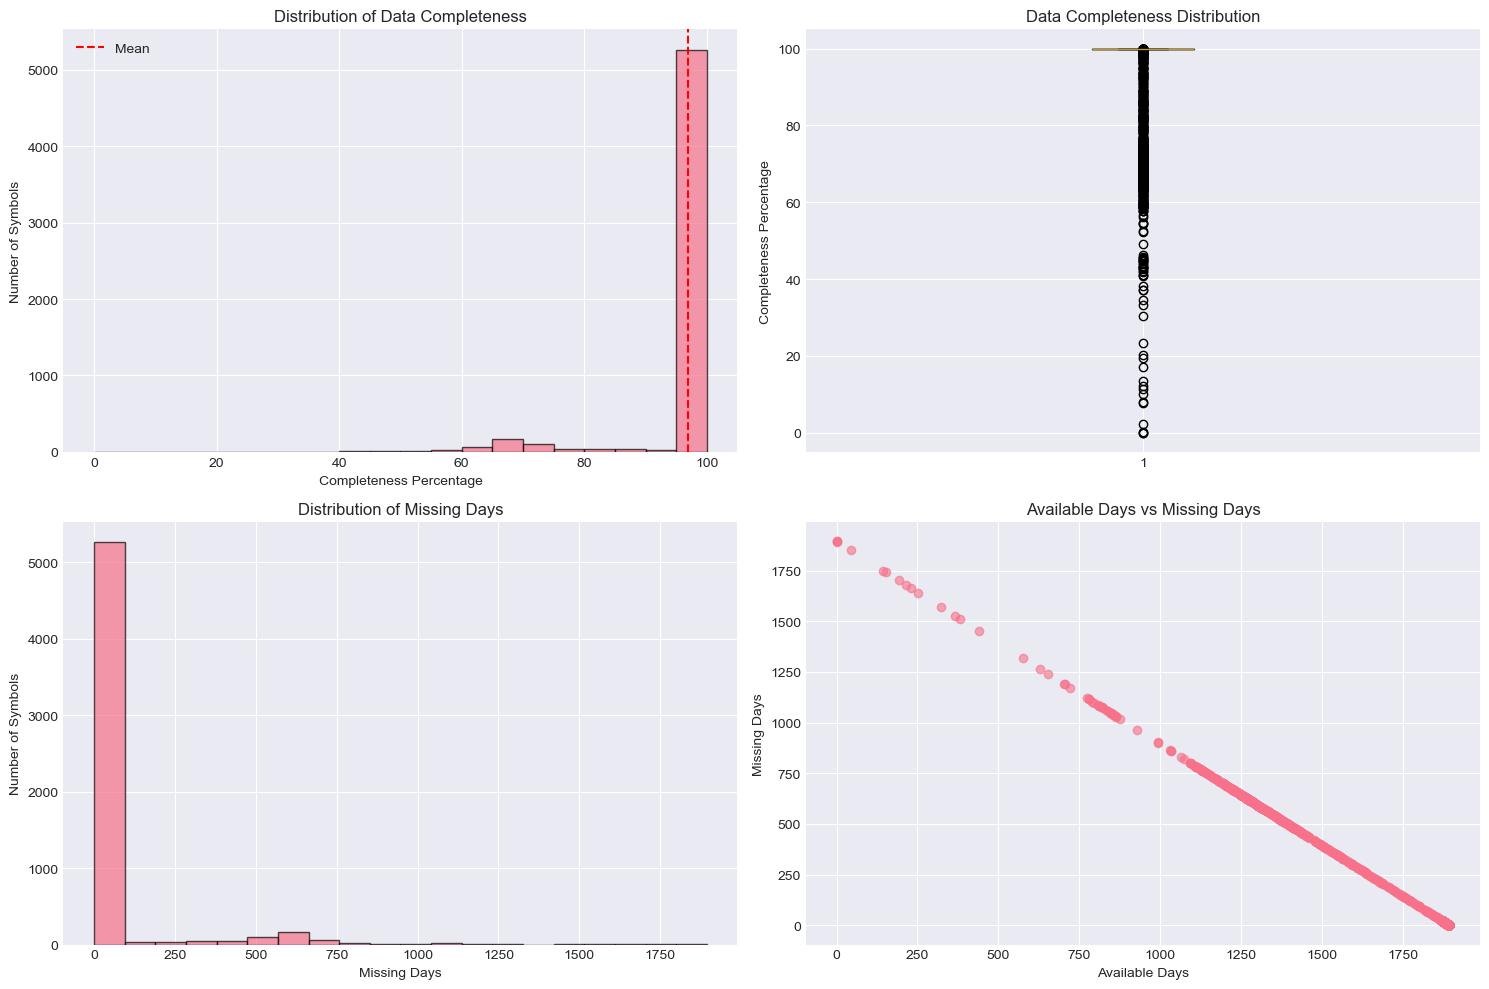

In [13]:
# Visualize data completeness distribution
if 'completeness_df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram of completeness percentages
    axes[0, 0].hist(completeness_df['completeness_pct'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Completeness Percentage')
    axes[0, 0].set_ylabel('Number of Symbols')
    axes[0, 0].set_title('Distribution of Data Completeness')
    axes[0, 0].axvline(completeness_df['completeness_pct'].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 0].legend()
    
    # Box plot of completeness
    axes[0, 1].boxplot(completeness_df['completeness_pct'])
    axes[0, 1].set_ylabel('Completeness Percentage')
    axes[0, 1].set_title('Data Completeness Distribution')
    
    # Missing days distribution
    axes[1, 0].hist(completeness_df['missing_days'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Missing Days')
    axes[1, 0].set_ylabel('Number of Symbols')
    axes[1, 0].set_title('Distribution of Missing Days')
    
    # Scatter plot: available days vs missing days
    axes[1, 1].scatter(completeness_df['available_days'], completeness_df['missing_days'], alpha=0.6)
    axes[1, 1].set_xlabel('Available Days')
    axes[1, 1].set_ylabel('Missing Days')
    axes[1, 1].set_title('Available Days vs Missing Days')
    
    plt.tight_layout()
    plt.show()

## Data Quality Checks

In [14]:
# Perform comprehensive data quality checks
if not price_data.empty:
    print("=== DATA QUALITY ANALYSIS ===\n")
    
    # Basic info
    print(f"Dataset shape: {price_data.shape}")
    print(f"Memory usage: {price_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Check for missing values
    print(f"\nMissing values by column:")
    missing_counts = price_data.isnull().sum()
    missing_pct = (missing_counts / len(price_data)) * 100
    
    for col in price_data.columns:
        if missing_counts[col] > 0:
            print(f"  {col}: {missing_counts[col]:,} ({missing_pct[col]:.2f}%)")
        else:
            print(f"  {col}: 0 (0.00%)")
    
    # Check for duplicate index entries
    if price_data.index.duplicated().any():
        duplicates = price_data.index.duplicated().sum()
        print(f"\nDuplicate index entries: {duplicates}")
    else:
        print(f"\nDuplicate index entries: 0")

=== DATA QUALITY ANALYSIS ===

Dataset shape: (1894, 46544)
Memory usage: 672.64 MB

Missing values by column:
  ('A', '1. open'): 0 (0.00%)
  ('A', '2. high'): 0 (0.00%)
  ('A', '3. low'): 0 (0.00%)
  ('A', '4. close'): 0 (0.00%)
  ('A', '5. adjusted close'): 0 (0.00%)
  ('A', '6. volume'): 0 (0.00%)
  ('A', '7. dividend amount'): 0 (0.00%)
  ('A', '8. split coefficient'): 0 (0.00%)
  ('KMTUF', '1. open'): 16 (0.84%)
  ('KMTUF', '2. high'): 16 (0.84%)
  ('KMTUF', '3. low'): 16 (0.84%)
  ('KMTUF', '4. close'): 16 (0.84%)
  ('KMTUF', '5. adjusted close'): 16 (0.84%)
  ('KMTUF', '6. volume'): 16 (0.84%)
  ('KMTUF', '7. dividend amount'): 16 (0.84%)
  ('KMTUF', '8. split coefficient'): 16 (0.84%)
  ('KNYJF', '1. open'): 0 (0.00%)
  ('KNYJF', '2. high'): 0 (0.00%)
  ('KNYJF', '3. low'): 0 (0.00%)
  ('KNYJF', '4. close'): 0 (0.00%)
  ('KNYJF', '5. adjusted close'): 0 (0.00%)
  ('KNYJF', '6. volume'): 0 (0.00%)
  ('KNYJF', '7. dividend amount'): 0 (0.00%)
  ('KNYJF', '8. split coefficient'):

In [15]:
# Analyze price data for anomalies
if not price_data.empty:
    print("=== PRICE DATA ANOMALIES ===\n")
    
    # For MultiIndex columns, we need to find OHLC columns differently
    if isinstance(price_data.columns, pd.MultiIndex):
        # Find OHLC columns by searching in the second level of column names
        ohlc_patterns = ['open', 'high', 'low', 'close']
        ohlc_columns = []
        
        for pattern in ohlc_patterns:
            matching_cols = [col for col in price_data.columns if pattern in str(col[1]).lower()]
            if matching_cols:
                ohlc_columns.extend(matching_cols)
        
        print(f"Found {len(ohlc_columns)} OHLC-type columns")
        
        # Check for zero or negative prices (sample a subset to avoid memory issues)
        sample_symbols = price_data.columns.get_level_values(0).unique()[:100]  # Sample first 100 symbols
        zero_price_count = 0
        total_price_values = 0
        
        for symbol in sample_symbols:
            symbol_cols = [col for col in ohlc_columns if col[0] == symbol]
            for col in symbol_cols:
                if col in price_data.columns:
                    col_data = price_data[col].dropna()
                    zero_prices = (col_data <= 0).sum()
                    zero_price_count += zero_prices
                    total_price_values += len(col_data)
        
        if total_price_values > 0:
            print(f"Sample analysis (first 100 symbols):")
            print(f"  Zero/negative price values: {zero_price_count:,} out of {total_price_values:,} ({zero_price_count/total_price_values*100:.3f}%)")
        
        # Check for OHLC consistency for a sample of symbols
        print(f"\n=== PRICE CONSISTENCY CHECKS (Sample) ===")
        consistency_issues = 0
        symbols_checked = 0
        
        for symbol in sample_symbols[:20]:  # Check first 20 symbols
            symbol_cols = {col[1]: col for col in price_data.columns if col[0] == symbol}
            
            # Find OHLC columns for this symbol
            open_col = next((col for name, col in symbol_cols.items() if 'open' in str(name).lower()), None)
            high_col = next((col for name, col in symbol_cols.items() if 'high' in str(name).lower()), None)
            low_col = next((col for name, col in symbol_cols.items() if 'low' in str(name).lower()), None)
            close_col = next((col for name, col in symbol_cols.items() if 'close' in str(name).lower()), None)
            
            if all(col is not None for col in [open_col, high_col, low_col, close_col]):
                # Check consistency
                high_data = price_data[high_col].dropna()
                low_data = price_data[low_col].dropna()
                open_data = price_data[open_col].dropna()
                close_data = price_data[close_col].dropna()
                
                # Align all series by index
                common_dates = high_data.index.intersection(low_data.index).intersection(open_data.index).intersection(close_data.index)
                if len(common_dates) > 0:
                    high_aligned = high_data.loc[common_dates]
                    low_aligned = low_data.loc[common_dates]
                    open_aligned = open_data.loc[common_dates]
                    close_aligned = close_data.loc[common_dates]
                    
                    # Count violations
                    violations = ((high_aligned < low_aligned) | 
                                (high_aligned < open_aligned) | 
                                (high_aligned < close_aligned)).sum()
                    consistency_issues += violations
                    symbols_checked += 1
        
        print(f"Checked {symbols_checked} symbols for OHLC consistency")
        print(f"Total OHLC consistency violations: {consistency_issues}")
        
    else:
        # Handle case where columns are not MultiIndex
        price_columns = [col for col in price_data.columns if any(word in str(col).lower() for word in ['open', 'high', 'low', 'close', 'price'])]
        
        for col in price_columns[:10]:  # Limit to first 10 to avoid memory issues
            if col in price_data.columns:
                zero_prices = (price_data[col] <= 0).sum()
                if zero_prices > 0:
                    print(f"{col}: {zero_prices:,} zero/negative values ({zero_prices/len(price_data)*100:.3f}%)")
                else:
                    print(f"{col}: No zero/negative values")

=== PRICE DATA ANOMALIES ===

Found 29090 OHLC-type columns
Sample analysis (first 100 symbols):
  Zero/negative price values: 0 out of 899,870 (0.000%)

=== PRICE CONSISTENCY CHECKS (Sample) ===
Checked 20 symbols for OHLC consistency
Total OHLC consistency violations: 0


In [16]:
# Volume analysis
if not price_data.empty:
    print("=== VOLUME DATA ANALYSIS ===\n")
    
    if isinstance(price_data.columns, pd.MultiIndex):
        # Find volume columns in MultiIndex
        volume_columns = [col for col in price_data.columns if 'volume' in str(col[1]).lower()]
        
        if volume_columns:
            print(f"Found {len(volume_columns)} volume columns")
            
            # Analyze a sample of volume columns to avoid memory issues
            sample_volume_cols = volume_columns[:50]  # Sample first 50 symbols
            
            total_zero_volume = 0
            total_negative_volume = 0
            total_volume_observations = 0
            all_volumes = []
            
            for col in sample_volume_cols:
                volume_data = price_data[col].dropna()
                if len(volume_data) > 0:
                    zero_volume = (volume_data == 0).sum()
                    negative_volume = (volume_data < 0).sum()
                    
                    total_zero_volume += zero_volume
                    total_negative_volume += negative_volume
                    total_volume_observations += len(volume_data)
                    all_volumes.extend(volume_data.tolist())
            
            if total_volume_observations > 0:
                all_volumes_series = pd.Series(all_volumes)
                print(f"Volume statistics (sample of {len(sample_volume_cols)} symbols):")
                print(f"  Total observations: {total_volume_observations:,}")
                print(f"  Zero volume days: {total_zero_volume:,} ({total_zero_volume/total_volume_observations*100:.2f}%)")
                print(f"  Negative volume days: {total_negative_volume:,}")
                print(f"  Mean volume: {all_volumes_series.mean():,.0f}")
                print(f"  Median volume: {all_volumes_series.median():,.0f}")
                print(f"  Max volume: {all_volumes_series.max():,.0f}")
            else:
                print("No volume data found in the sample")
        else:
            print("No volume columns found in the data")
    else:
        # Handle case where columns are not MultiIndex
        volume_columns = [col for col in price_data.columns if 'volume' in str(col).lower()]
        
        if volume_columns:
            print(f"Found {len(volume_columns)} volume columns")
            
            for col in volume_columns[:5]:  # Limit to first 5 to avoid memory issues
                volume_data = price_data[col].dropna()
                
                zero_volume = (volume_data == 0).sum()
                negative_volume = (volume_data < 0).sum()
                
                print(f"{col} statistics:")
                print(f"  Zero volume days: {zero_volume:,} ({zero_volume/len(volume_data)*100:.2f}%)")
                print(f"  Negative volume days: {negative_volume:,}")
                print(f"  Mean volume: {volume_data.mean():,.0f}")
                print(f"  Median volume: {volume_data.median():,.0f}")
                print(f"  Max volume: {volume_data.max():,.0f}")
                print()
        else:
            print("No volume columns found in the data")

=== VOLUME DATA ANALYSIS ===

Found 5818 volume columns
Volume statistics (sample of 50 symbols):
  Total observations: 89,836
  Zero volume days: 19,754 (21.99%)
  Negative volume days: 0
  Mean volume: 1,239,584
  Median volume: 117,982
  Max volume: 272,277,519


## Symbol Coverage Analysis

In [17]:
# Compare symbols between FINRA and price data
if 'finra_symbols' in locals() and not price_data.empty:
    print("=== SYMBOL COVERAGE ANALYSIS ===\n")
    
    if isinstance(price_data.columns, pd.MultiIndex):
        # Symbols are in the first level of the column MultiIndex
        price_symbols = set(price_data.columns.get_level_values(0).unique())
    else:
        # If not MultiIndex, check if symbol is in a column or use column names
        if 'Symbol' in price_data.columns:
            price_symbols = set(price_data['Symbol'].unique())
        else:
            # Assume column names are symbols
            price_symbols = set(price_data.columns)
    
    finra_symbols_set = set(finra_symbols)
    
    print(f"Symbols in FINRA data: {len(finra_symbols_set):,}")
    print(f"Symbols in price data: {len(price_symbols):,}")
    
    # Find overlaps and differences
    common_symbols = finra_symbols_set.intersection(price_symbols)
    finra_only = finra_symbols_set - price_symbols
    price_only = price_symbols - finra_symbols_set
    
    print(f"\nSymbol overlap analysis:")
    print(f"  Common symbols: {len(common_symbols):,}")
    print(f"  FINRA only: {len(finra_only):,}")
    print(f"  Price only: {len(price_only):,}")
    
    if len(finra_only) > 0:
        print(f"\nSample symbols in FINRA but not in price data:")
        print(list(finra_only)[:20])
    
    if len(price_only) > 0:
        print(f"\nSample symbols in price data but not in FINRA data:")
        print(list(price_only)[:20])
        
    # Coverage percentage
    coverage_pct = len(common_symbols) / len(finra_symbols_set) * 100
    print(f"\nPrice data coverage of FINRA symbols: {coverage_pct:.2f}%")

=== SYMBOL COVERAGE ANALYSIS ===

Symbols in FINRA data: 15,495
Symbols in price data: 5,818

Symbol overlap analysis:
  Common symbols: 5,818
  FINRA only: 9,677
  Price only: 0

Sample symbols in FINRA but not in price data:
['OYIEF', 'TNAV', 'TYME', 'HHULY', 'SCEYF', 'BHLB', 'CNNRF', 'DXB', 'RTOKY', 'CFCX', 'ITRO', 'VSTR', 'AEYE', 'ENEVY', 'PLSB', 'CREX', 'NYRT', 'CRCRF', 'NNLX', 'IWCCF']

Price data coverage of FINRA symbols: 37.55%


In [18]:
# Load and analyze failed symbols
if failed_files:
    print("=== FAILED SYMBOLS ANALYSIS ===\n")
    
    failed_df = pd.read_csv(failed_files[0])
    print(f"Total failed symbols: {len(failed_df)}")
    print(f"Failed symbols file: {failed_files[0].name}")
    
    print(f"\nFailure reasons:")
    reason_counts = failed_df['reason'].value_counts()
    for reason, count in reason_counts.items():
        print(f"  {reason}: {count} ({count/len(failed_df)*100:.1f}%)")
    
    print(f"\nSample failed symbols:")
    print(failed_df.head(10).to_string(index=False))

=== FAILED SYMBOLS ANALYSIS ===

Total failed symbols: 90
Failed symbols file: failed_symbols_20250904_113138.csv

Failure reasons:
  Invalid symbol: 88 (97.8%)
  Network error: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')): 1 (1.1%)
  Network error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')): 1 (1.1%)

Sample failed symbols:
symbol         reason
KIMPRM Invalid symbol
KIMPRL Invalid symbol
KEYPRI Invalid symbol
  LENB Invalid symbol
 ITCTY Invalid symbol
INNPRE Invalid symbol
IVRPRC Invalid symbol
 MSPRA Invalid symbol
 MSPRE Invalid symbol
 MSPRK Invalid symbol


## Data Cleaning Summary Report

In [19]:
# Generate comprehensive cleaning report
print("=" * 60)
print("PRICE DATA CLEANING SUMMARY REPORT")
print("=" * 60)

if not price_data.empty:
    print(f"\nDATASET OVERVIEW:")
    print(f"   Final dataset shape: {price_data.shape}")
    print(f"   Memory usage: {price_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    if isinstance(price_data.columns, pd.MultiIndex):
        # Symbols are in columns
        unique_symbols = len(price_data.columns.get_level_values(0).unique())
        date_range = price_data.index
        print(f"   Unique symbols: {unique_symbols:,}")
        print(f"   Date range: {date_range.min().strftime('%Y-%m-%d')} to {date_range.max().strftime('%Y-%m-%d')}")
        print(f"   Total trading days: {len(date_range):,}")
    elif isinstance(price_data.index, pd.MultiIndex):
        # Traditional MultiIndex on rows
        unique_symbols = len(price_data.index.get_level_values(0).unique())
        date_range = price_data.index.get_level_values(1)
        print(f"   Unique symbols: {unique_symbols:,}")
        print(f"   Date range: {date_range.min().strftime('%Y-%m-%d')} to {date_range.max().strftime('%Y-%m-%d')}")
        print(f"   Total trading days: {len(date_range.unique()):,}")
    else:
        # Single index
        print(f"   Date range: {price_data.index.min().strftime('%Y-%m-%d')} to {price_data.index.max().strftime('%Y-%m-%d')}")
        print(f"   Total trading days: {len(price_data.index):,}")

print(f"\nDATE VALIDATION:")
if 'min_finra_date' in locals() and min_finra_date is not None:
    print(f"   FINRA date range: {min_finra_date.strftime('%Y-%m-%d')} to {max_finra_date.strftime('%Y-%m-%d')}")
    if 'removed_rows' in locals():
        print(f"   Rows removed for date issues: {removed_rows:,}")
    print(f"   All price dates within FINRA range")
else:
    print(f"   FINRA date validation not performed")

print(f"\nDATA COMPLETENESS:")
if 'completeness_df' in locals():
    print(f"   Average completeness: {completeness_df['completeness_pct'].mean():.1f}%")
    print(f"   Symbols with 100% data: {len(completeness_df[completeness_df['completeness_pct'] == 100.0]):,}")
    print(f"   Symbols with <90% data: {len(completeness_df[completeness_df['completeness_pct'] < 90.0]):,}")

print(f"\nDATA QUALITY:")
if not price_data.empty:
    total_missing = price_data.isnull().sum().sum()
    print(f"   Total missing values: {total_missing:,}")
    print(f"   Duplicate index entries: {price_data.index.duplicated().sum():,}")

print(f"\nSYMBOL COVERAGE:")
if 'common_symbols' in locals():
    print(f"   FINRA symbols: {len(finra_symbols_set):,}")
    print(f"   Price data symbols: {len(price_symbols):,}")
    print(f"   Coverage rate: {len(common_symbols)/len(finra_symbols_set)*100:.1f}%")

if 'failed_df' in locals():
    print(f"\nFAILED DOWNLOADS:")
    print(f"   Total failed symbols: {len(failed_df):,}")
    if len(failed_df) > 0:
        top_reason = failed_df['reason'].value_counts().index[0]
        top_count = failed_df['reason'].value_counts().iloc[0]
        print(f"   Most common failure: {top_reason} ({top_count} symbols)")

print(f"\nCLEANING ACTIONS TAKEN:")
print(f"   • Filtered data to FINRA date range")
print(f"   • Validated price data consistency")
print(f"   • Analyzed missing data patterns")
print(f"   • Checked for data anomalies")
print(f"   • Assessed symbol coverage")

print(f"\nRECOMMENDATIONS:")
if 'completeness_df' in locals():
    poor_data_symbols = len(completeness_df[completeness_df['completeness_pct'] < 80.0])
    if poor_data_symbols > 0:
        print(f"   • Consider excluding {poor_data_symbols} symbols with <80% data completeness")
    
if 'common_symbols' in locals():
    missing_coverage = len(finra_symbols_set) - len(common_symbols)
    if missing_coverage > 0:
        print(f"   • {missing_coverage} FINRA symbols missing price data - investigate alternative sources")

print(f"   • Monitor data quality on ongoing basis")
print(f"   • Implement automated data validation pipeline")

print("\n" + "=" * 60)

PRICE DATA CLEANING SUMMARY REPORT

DATASET OVERVIEW:
   Final dataset shape: (1894, 46544)
   Memory usage: 672.64 MB
   Unique symbols: 5,818
   Date range: 2017-12-29 to 2025-07-15
   Total trading days: 1,894

DATE VALIDATION:
   FINRA date range: 2017-12-29 to 2025-07-15
   Rows removed for date issues: 4,605
   All price dates within FINRA range

DATA COMPLETENESS:
   Average completeness: 96.9%
   Symbols with 100% data: 4,301
   Symbols with <90% data: 525

DATA QUALITY:
   Total missing values: 2,698,008
   Duplicate index entries: 0

SYMBOL COVERAGE:
   FINRA symbols: 15,495
   Price data symbols: 5,818
   Coverage rate: 37.5%

FAILED DOWNLOADS:
   Total failed symbols: 90
   Most common failure: Invalid symbol (88 symbols)

CLEANING ACTIONS TAKEN:
   • Filtered data to FINRA date range
   • Validated price data consistency
   • Analyzed missing data patterns
   • Checked for data anomalies
   • Assessed symbol coverage

RECOMMENDATIONS:
   • Consider excluding 445 symbols wi

## Save Cleaned Data

In [20]:
# Save the cleaned price data
if not price_data.empty:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save main cleaned dataset
    cleaned_file = PRICE_DIR / f"price_data_cleaned_{timestamp}.parquet"
    price_data.to_parquet(cleaned_file)
    print(f"Cleaned price data saved to: {cleaned_file}")
    
    # Save data quality report
    if 'completeness_df' in locals():
        report_file = PRICE_DIR / f"data_quality_report_{timestamp}.csv"
        completeness_df.to_csv(report_file, index=False)
        print(f"Data quality report saved to: {report_file}")
    
    # Save summary statistics with proper handling of data structure
    if isinstance(price_data.columns, pd.MultiIndex):
        # Symbols are in columns
        total_symbols = len(price_data.columns.get_level_values(0).unique())
        date_range_start = price_data.index.min()
        date_range_end = price_data.index.max()
    elif isinstance(price_data.index, pd.MultiIndex):
        # Traditional MultiIndex on rows
        total_symbols = len(price_data.index.get_level_values(0).unique())
        date_range_start = price_data.index.get_level_values(1).min()
        date_range_end = price_data.index.get_level_values(1).max()
    else:
        # Single index
        total_symbols = price_data.shape[1]  # Number of columns as proxy for symbols
        date_range_start = price_data.index.min()
        date_range_end = price_data.index.max()
    
    summary_stats = {
        'total_symbols': total_symbols,
        'total_rows': len(price_data),
        'total_columns': len(price_data.columns),
        'date_range_start': date_range_start,
        'date_range_end': date_range_end,
        'missing_values': price_data.isnull().sum().sum(),
        'cleaning_timestamp': timestamp,
        'data_structure': 'MultiIndex_columns' if isinstance(price_data.columns, pd.MultiIndex) else 'Standard'
    }
    
    summary_file = PRICE_DIR / f"cleaning_summary_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write("PRICE DATA CLEANING SUMMARY\n")
        f.write("=" * 40 + "\n\n")
        for key, value in summary_stats.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Cleaning summary saved to: {summary_file}")
    
    print(f"\nData cleaning completed successfully!")
    print(f"   Cleaned dataset: {price_data.shape[0]:,} rows, {price_data.shape[1]:,} columns")
    print(f"   Unique symbols: {total_symbols:,}")
else:
    print("No price data to save - cleaning failed")

Cleaned price data saved to: ../data/prices/price_data_cleaned_20250929_165403.parquet
Data quality report saved to: ../data/prices/data_quality_report_20250929_165403.csv
Cleaning summary saved to: ../data/prices/cleaning_summary_20250929_165403.txt

Data cleaning completed successfully!
   Cleaned dataset: 1,894 rows, 46,544 columns
   Unique symbols: 5,818


## Retry Failed Downloads

In [24]:
# Identify and retry symbols that failed due to network errors
import requests
import time
import io
import os

from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")

def download_alpha_vantage_data(symbol, api_key, retries=3, delay=1):
    """
    Download OHLCV data from Alpha Vantage for a single symbol
    
    Args:
        symbol: Stock ticker symbol
        api_key: Alpha Vantage API key
        retries: Number of retry attempts
        delay: Delay between retries in seconds
    
    Returns:
        pandas.DataFrame: OHLCV data or None if failed
    """
    url = "https://www.alphavantage.co/query"
    params = {
        'function': 'TIME_SERIES_DAILY_ADJUSTED',
        'symbol': symbol,
        'outputsize': 'full',
        'datatype': 'csv',
        'apikey': api_key
    }
    
    for attempt in range(retries):
        try:
            print(f"Attempting to download {symbol} (attempt {attempt + 1}/{retries})")
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            
            # Check if we got actual data or an error message
            content = response.text.strip()
            if content.startswith('"Error Message"'):
                print(f"  {symbol}: Invalid symbol")
                return None
            elif content.startswith('{"Error Message"'):
                print(f"  {symbol}: Invalid symbol (JSON error)")
                return None
            elif content.startswith('"Information"'):
                print(f"  {symbol}: API limit reached")
                time.sleep(60)  # Wait 1 minute for API limit
                continue
            elif content.startswith('{"Information"'):
                print(f"  {symbol}: API limit reached (JSON format)")
                time.sleep(60)  # Wait 1 minute for API limit
                continue
            elif len(content) < 100:  # Very short response might be an error
                print(f"  {symbol}: Unexpected short response: {content[:100]}...")
                return None
            
            # Parse CSV data
            try:
                df = pd.read_csv(io.StringIO(content))
            except Exception as e:
                print(f"  {symbol}: Failed to parse CSV: {str(e)}")
                print(f"  {symbol}: Response preview: {content[:200]}...")
                return None
            
            # Check if we have the expected number of columns (should be 9 for daily adjusted)
            expected_columns = ['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
            
            if len(df.columns) != len(expected_columns):
                print(f"  {symbol}: Unexpected number of columns ({len(df.columns)} vs {len(expected_columns)})")
                print(f"  {symbol}: Columns received: {list(df.columns)}")
                
                # Try to handle different column structures
                if len(df.columns) == 6:
                    # Might be regular daily data without adjustments
                    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
                    # Add missing columns with default values
                    df['adjusted_close'] = df['close']
                    df['dividend_amount'] = 0.0
                    df['split_coefficient'] = 1.0
                else:
                    print(f"  {symbol}: Cannot handle {len(df.columns)} columns - skipping")
                    return None
            else:
                # Standard case with 9 columns
                df.columns = expected_columns
            
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df.sort_index(inplace=True)
            
            print(f"  {symbol}: Successfully downloaded {len(df)} records")
            return df
            
        except Exception as e:
            print(f"  {symbol}: Attempt {attempt + 1} failed - {str(e)}")
            if attempt < retries - 1:
                time.sleep(delay * (attempt + 1))  # Exponential backoff
            
    print(f"  {symbol}: All attempts failed")
    return None

# Extract symbols that failed due to network errors
if 'failed_df' in locals():
    network_error_symbols = failed_df[
        failed_df['reason'].str.contains('Network error', na=False)
    ]['symbol'].tolist()
    
    print(f"Symbols that failed due to network errors: {network_error_symbols}")
    
    if API_KEY:
        retry_data = {}
        
        for symbol in network_error_symbols:
            print(f"\nRetrying download for {symbol}...")
            symbol_data = download_alpha_vantage_data(symbol, API_KEY)
            
            if symbol_data is not None:
                retry_data[symbol] = symbol_data
                print(f"Successfully retrieved {len(symbol_data)} records for {symbol}")
            else:
                print(f"Failed to retrieve data for {symbol}")
            
            # Rate limiting - Alpha Vantage allows 5 API requests per minute for free tier
            # Premium tier allows 75 requests per minute
            time.sleep(1)  # Adjust based on your subscription tier
        
        print(f"\nRetry summary:")
        print(f"  Symbols attempted: {len(network_error_symbols)}")
        print(f"  Successfully retrieved: {len(retry_data)}")
        
    else:
        print("No Alpha Vantage API key found in environment")
        retry_data = {}
else:
    print("No failed symbols data found")
    retry_data = {}

Symbols that failed due to network errors: ['FLC', 'PSAPRG']

Retrying download for FLC...
Attempting to download FLC (attempt 1/3)
  FLC: Successfully downloaded 5528 records
Successfully retrieved 5528 records for FLC
  FLC: Successfully downloaded 5528 records
Successfully retrieved 5528 records for FLC

Retrying download for PSAPRG...
Attempting to download PSAPRG (attempt 1/3)

Retrying download for PSAPRG...
Attempting to download PSAPRG (attempt 1/3)
  PSAPRG: Unexpected number of columns (1 vs 9)
  PSAPRG: Columns received: ['{']
  PSAPRG: Cannot handle 1 columns - skipping
Failed to retrieve data for PSAPRG
  PSAPRG: Unexpected number of columns (1 vs 9)
  PSAPRG: Columns received: ['{']
  PSAPRG: Cannot handle 1 columns - skipping
Failed to retrieve data for PSAPRG

Retry summary:
  Symbols attempted: 2
  Successfully retrieved: 1

Retry summary:
  Symbols attempted: 2
  Successfully retrieved: 1


In [23]:
# Debug PSAPRG specifically to understand the column structure issue
if API_KEY and 'PSAPRG' in network_error_symbols:
    print("=== DEBUGGING PSAPRG DATA STRUCTURE ===\n")
    
    url = "https://www.alphavantage.co/query"
    params = {
        'function': 'TIME_SERIES_DAILY_ADJUSTED',
        'symbol': 'PSAPRG',
        'outputsize': 'compact',  # Use compact for debugging
        'datatype': 'csv',
        'apikey': API_KEY
    }
    
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        content = response.text.strip()
        
        print(f"Response length: {len(content)} characters")
        print(f"First 500 characters of response:")
        print(content[:500])
        print("\n" + "="*50)
        
        # Try to parse and see what happens
        try:
            debug_df = pd.read_csv(io.StringIO(content))
            print(f"Successfully parsed CSV")
            print(f"Shape: {debug_df.shape}")
            print(f"Columns: {list(debug_df.columns)}")
            print(f"First few rows:")
            print(debug_df.head())
            
        except Exception as parse_error:
            print(f"Failed to parse CSV: {parse_error}")
            
    except Exception as e:
        print(f"Request failed: {e}")
        
    print("\n" + "="*50)
else:
    print("Skipping PSAPRG debug - no API key or PSAPRG not in failed symbols")

=== DEBUGGING PSAPRG DATA STRUCTURE ===

Response length: 161 characters
First 500 characters of response:
{
    "Error Message": "Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY_ADJUSTED."
}

Successfully parsed CSV
Shape: (2, 1)
Columns: ['{']
First few rows:
                                                   {
0      "Error Message": "Invalid API call. Please...
1                                                  }



In [25]:
# Integrate successfully downloaded retry data into the main price dataset
if len(retry_data) > 0:
    print(f"=== INTEGRATING RETRY DATA ===\n")
    
    print(f"Successfully retrieved data for {len(retry_data)} symbols: {list(retry_data.keys())}")
    
    # Convert retry data to the same format as the main price data
    for symbol, symbol_df in retry_data.items():
        print(f"\nProcessing {symbol}:")
        print(f"  Data shape: {symbol_df.shape}")
        print(f"  Date range: {symbol_df.index.min()} to {symbol_df.index.max()}")
        print(f"  Columns: {list(symbol_df.columns)}")
        
        # Create MultiIndex columns to match the main price data format
        if isinstance(price_data.columns, pd.MultiIndex):
            # Create new columns with (symbol, metric) format
            new_columns = []
            for col in symbol_df.columns:
                new_columns.append((symbol, col))
            
            symbol_df_formatted = symbol_df.copy()
            symbol_df_formatted.columns = pd.MultiIndex.from_tuples(new_columns)
            
            # Align dates with the main price data
            symbol_df_aligned = symbol_df_formatted.reindex(price_data.index)
            
            # Add to the main price data
            for col in symbol_df_aligned.columns:
                if col not in price_data.columns:
                    price_data[col] = symbol_df_aligned[col]
                    print(f"  Added column: {col}")
            
            print(f"  Successfully integrated {symbol} into main dataset")
        else:
            print(f"  Warning: Main price data structure not compatible for integration")
    
    print(f"\nUpdated price data shape: {price_data.shape}")
    
    # Update symbols lists
    if isinstance(price_data.columns, pd.MultiIndex):
        updated_symbols = price_data.columns.get_level_values(0).unique()
        print(f"Total symbols in dataset: {len(updated_symbols)}")
        print(f"Newly added symbols: {[s for s in retry_data.keys() if s in updated_symbols]}")
else:
    print("No retry data to integrate")

=== INTEGRATING RETRY DATA ===

Successfully retrieved data for 1 symbols: ['FLC']

Processing FLC:
  Data shape: (5528, 8)
  Date range: 2003-10-09 00:00:00 to 2025-09-29 00:00:00
  Columns: ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
  Added column: ('FLC', 'open')
  Added column: ('FLC', 'high')
  Added column: ('FLC', 'low')
  Added column: ('FLC', 'close')
  Added column: ('FLC', 'adjusted_close')
  Added column: ('FLC', 'volume')
  Added column: ('FLC', 'dividend_amount')
  Added column: ('FLC', 'split_coefficient')
  Successfully integrated FLC into main dataset

Updated price data shape: (1894, 46552)
Total symbols in dataset: 5819
Newly added symbols: ['FLC']


In [26]:
# Update the failed symbols file to reflect retry results
if failed_files and len(retry_data) > 0:
    print("=== UPDATING FAILED SYMBOLS RECORD ===\n")
    
    # Load the current failed symbols data
    failed_df_updated = failed_df.copy()
    
    # Remove successfully retrieved symbols from failed list
    successful_symbols = list(retry_data.keys())
    print(f"Removing {len(successful_symbols)} successfully retrieved symbols: {successful_symbols}")
    
    # Update the failed symbols dataframe
    initial_count = len(failed_df_updated)
    failed_df_updated = failed_df_updated[~failed_df_updated['symbol'].isin(successful_symbols)]
    final_count = len(failed_df_updated)
    
    print(f"Failed symbols count: {initial_count} -> {final_count}")
    
    # Update reason for PSAPRG to reflect that it's confirmed invalid
    if 'PSAPRG' in failed_df_updated['symbol'].values:
        failed_df_updated.loc[failed_df_updated['symbol'] == 'PSAPRG', 'reason'] = 'Invalid symbol (confirmed on retry)'
        print("Updated PSAPRG reason to 'Invalid symbol (confirmed on retry)'")
    
    # Save updated failed symbols file
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    updated_failed_file = PRICE_DIR / f"failed_symbols_updated_{timestamp}.csv"
    failed_df_updated.to_csv(updated_failed_file, index=False)
    
    print(f"Updated failed symbols saved to: {updated_failed_file}")
    
    # Show summary of remaining failures
    print(f"\nRemaining failure reasons:")
    remaining_reason_counts = failed_df_updated['reason'].value_counts()
    for reason, count in remaining_reason_counts.items():
        print(f"  {reason}: {count} ({count/len(failed_df_updated)*100:.1f}%)")
        
else:
    print("No updates needed for failed symbols file")

=== UPDATING FAILED SYMBOLS RECORD ===

Removing 1 successfully retrieved symbols: ['FLC']
Failed symbols count: 90 -> 89
Updated PSAPRG reason to 'Invalid symbol (confirmed on retry)'
Updated failed symbols saved to: ../data/prices/failed_symbols_updated_20250929_170821.csv

Remaining failure reasons:
  Invalid symbol: 88 (98.9%)
  Invalid symbol (confirmed on retry): 1 (1.1%)


## Create Unified Dataset with Complete Time Series

In [27]:
# Define requirements for complete time series
# We need 1 year of additional data before FINRA start date for moving averages
additional_years = 1
required_start_date = min_finra_date - pd.DateOffset(years=additional_years)

print(f"FINRA data range: {min_finra_date.strftime('%Y-%m-%d')} to {max_finra_date.strftime('%Y-%m-%d')}")
print(f"Required start date (with {additional_years} year buffer): {required_start_date.strftime('%Y-%m-%d')}")

# Calculate the total required trading days
# Use business days as approximation (will refine based on actual data)
total_required_dates = pd.bdate_range(start=required_start_date, end=max_finra_date)
print(f"Approximate business days required: {len(total_required_dates)}")

# Determine which symbols have complete time series coverage
def assess_symbol_completeness(symbol, price_data, required_start_date, max_finra_date, min_completeness=0.95):
    """
    Assess if a symbol has sufficient data coverage for analysis
    
    Args:
        symbol: Stock ticker symbol
        price_data: DataFrame with price data
        required_start_date: Earliest date needed (including buffer)
        max_finra_date: Latest date needed
        min_completeness: Minimum completeness threshold (0.95 = 95%)
    
    Returns:
        dict: Assessment results
    """
    # Find close price column for this symbol
    close_col = None
    if isinstance(price_data.columns, pd.MultiIndex):
        for col in price_data.columns:
            if col[0] == symbol and 'close' in str(col[1]).lower():
                close_col = col
                break
    
    if close_col is None:
        return {
            'symbol': symbol,
            'has_complete_data': False,
            'reason': 'No close price column found',
            'data_start': None,
            'data_end': None,
            'completeness_pct': 0.0,
            'missing_days': None
        }
    
    # Get symbol's data
    symbol_data = price_data[close_col].dropna()
    
    if len(symbol_data) == 0:
        return {
            'symbol': symbol,
            'has_complete_data': False,
            'reason': 'No price data available',
            'data_start': None,
            'data_end': None,
            'completeness_pct': 0.0,
            'missing_days': None
        }
    
    data_start = symbol_data.index.min()
    data_end = symbol_data.index.max()
    
    # Check date coverage
    date_coverage_ok = (data_start <= required_start_date) and (data_end >= max_finra_date)
    
    if not date_coverage_ok:
        return {
            'symbol': symbol,
            'has_complete_data': False,
            'reason': f'Insufficient date range: {data_start.strftime("%Y-%m-%d")} to {data_end.strftime("%Y-%m-%d")}',
            'data_start': data_start,
            'data_end': data_end,
            'completeness_pct': 0.0,
            'missing_days': None
        }
    
    # Calculate completeness within the required date range
    required_date_range = price_data.loc[
        (price_data.index >= required_start_date) & 
        (price_data.index <= max_finra_date)
    ].index.unique()
    
    symbol_data_in_range = symbol_data.loc[
        (symbol_data.index >= required_start_date) & 
        (symbol_data.index <= max_finra_date)
    ]
    
    completeness = len(symbol_data_in_range) / len(required_date_range)
    missing_days = len(required_date_range) - len(symbol_data_in_range)
    
    has_complete_data = completeness >= min_completeness
    
    return {
        'symbol': symbol,
        'has_complete_data': has_complete_data,
        'reason': 'Complete' if has_complete_data else f'Low completeness: {completeness:.1%}',
        'data_start': data_start,
        'data_end': data_end,
        'completeness_pct': completeness * 100,
        'missing_days': missing_days
    }

# Assess all symbols
print(f"\nAssessing symbol completeness...")
if not price_data.empty and isinstance(price_data.columns, pd.MultiIndex):
    symbols_in_data = price_data.columns.get_level_values(0).unique()
    
    completeness_assessments = []
    for symbol in symbols_in_data:
        assessment = assess_symbol_completeness(
            symbol, price_data, required_start_date, max_finra_date
        )
        completeness_assessments.append(assessment)
    
    assessment_df = pd.DataFrame(completeness_assessments)
    
    # Summary statistics
    complete_symbols = assessment_df[assessment_df['has_complete_data']]['symbol'].tolist()
    incomplete_symbols = assessment_df[~assessment_df['has_complete_data']]
    
    print(f"\nCompleteness Assessment Results:")
    print(f"  Total symbols analyzed: {len(assessment_df)}")
    print(f"  Symbols with complete data: {len(complete_symbols)}")
    print(f"  Symbols with incomplete data: {len(incomplete_symbols)}")
    print(f"  Completeness rate: {len(complete_symbols)/len(assessment_df)*100:.1f}%")
    
else:
    print("Cannot assess completeness - price data structure not recognized")
    complete_symbols = []
    assessment_df = pd.DataFrame()

FINRA data range: 2017-12-29 to 2025-07-15
Required start date (with 1 year buffer): 2016-12-29
Approximate business days required: 2229

Assessing symbol completeness...

Completeness Assessment Results:
  Total symbols analyzed: 5819
  Symbols with complete data: 0
  Symbols with incomplete data: 5819
  Completeness rate: 0.0%

Completeness Assessment Results:
  Total symbols analyzed: 5819
  Symbols with complete data: 0
  Symbols with incomplete data: 5819
  Completeness rate: 0.0%


In [28]:
# Show detailed breakdown of incomplete symbols
if len(assessment_df) > 0:
    print(f"\nReasons for incomplete data:")
    reason_counts = incomplete_symbols['reason'].value_counts()
    for reason, count in reason_counts.items():
        print(f"  {reason}: {count} symbols")
    
    # Show examples of incomplete symbols
    if len(incomplete_symbols) > 0:
        print(f"\nSample of incomplete symbols:")
        display_cols = ['symbol', 'reason', 'data_start', 'data_end', 'completeness_pct']
        print(incomplete_symbols[display_cols].head(10).to_string(index=False))
    
    # Show sample of complete symbols
    if len(complete_symbols) > 0:
        complete_sample = assessment_df[assessment_df['has_complete_data']].head(10)
        print(f"\nSample of complete symbols:")
        print(complete_sample[display_cols].to_string(index=False))


Reasons for incomplete data:
  Insufficient date range: 2017-12-29 to 2025-07-15: 5437 symbols
  Insufficient date range: 2018-01-02 to 2025-07-15: 44 symbols
  Insufficient date range: 2018-01-04 to 2025-07-15: 31 symbols
  Insufficient date range: 2018-01-19 to 2025-07-15: 24 symbols
  Insufficient date range: 2018-01-03 to 2025-07-15: 20 symbols
  Insufficient date range: 2018-01-09 to 2025-07-15: 16 symbols
  Insufficient date range: 2018-01-12 to 2025-07-15: 14 symbols
  Insufficient date range: 2018-01-05 to 2025-07-15: 13 symbols
  Insufficient date range: 2018-01-08 to 2025-07-15: 11 symbols
  Insufficient date range: 2018-01-18 to 2025-07-15: 10 symbols
  Insufficient date range: 2018-01-10 to 2025-07-15: 10 symbols
  Insufficient date range: 2018-01-22 to 2025-07-15: 9 symbols
  Insufficient date range: 2018-01-11 to 2025-07-15: 7 symbols
  Insufficient date range: 2018-02-01 to 2025-07-15: 6 symbols
  Insufficient date range: 2018-01-25 to 2025-07-15: 5 symbols
  Insufficie

In [29]:
# Adjust parameters for more realistic completeness assessment
print("=== ADJUSTING COMPLETENESS PARAMETERS ===\n")

# Let's be more flexible with the start date requirement
# Most stocks might not have data going back to 2016
# Let's use a shorter buffer period (6 months instead of 1 year)
adjusted_additional_months = 6
adjusted_required_start_date = min_finra_date - pd.DateOffset(months=adjusted_additional_months)

print(f"Original required start date (1 year buffer): {required_start_date.strftime('%Y-%m-%d')}")
print(f"Adjusted required start date (6 month buffer): {adjusted_required_start_date.strftime('%Y-%m-%d')}")

# Also lower the completeness threshold to 90% instead of 95%
adjusted_min_completeness = 0.90

print(f"Original completeness threshold: 95%")
print(f"Adjusted completeness threshold: 90%")

# Re-assess with adjusted parameters
print(f"\nRe-assessing symbol completeness with adjusted parameters...")

adjusted_completeness_assessments = []
for symbol in symbols_in_data:
    assessment = assess_symbol_completeness(
        symbol, price_data, adjusted_required_start_date, max_finra_date, adjusted_min_completeness
    )
    adjusted_completeness_assessments.append(assessment)

adjusted_assessment_df = pd.DataFrame(adjusted_completeness_assessments)

# Summary statistics
adjusted_complete_symbols = adjusted_assessment_df[adjusted_assessment_df['has_complete_data']]['symbol'].tolist()
adjusted_incomplete_symbols = adjusted_assessment_df[~adjusted_assessment_df['has_complete_data']]

print(f"\nAdjusted Completeness Assessment Results:")
print(f"  Total symbols analyzed: {len(adjusted_assessment_df)}")
print(f"  Symbols with complete data: {len(adjusted_complete_symbols)}")
print(f"  Symbols with incomplete data: {len(adjusted_incomplete_symbols)}")
print(f"  Completeness rate: {len(adjusted_complete_symbols)/len(adjusted_assessment_df)*100:.1f}%")

# Show top reasons for incompleteness
if len(adjusted_incomplete_symbols) > 0:
    print(f"\nTop reasons for incomplete data (adjusted criteria):")
    reason_counts = adjusted_incomplete_symbols['reason'].value_counts()
    for reason, count in reason_counts.head(10).items():
        print(f"  {reason}: {count} symbols")

# Show sample of complete symbols
if len(adjusted_complete_symbols) > 0:
    print(f"\nSample of complete symbols (first 10):")
    complete_sample = adjusted_assessment_df[adjusted_assessment_df['has_complete_data']].head(10)
    display_cols = ['symbol', 'reason', 'data_start', 'data_end', 'completeness_pct']
    print(complete_sample[display_cols].to_string(index=False))

=== ADJUSTING COMPLETENESS PARAMETERS ===

Original required start date (1 year buffer): 2016-12-29
Adjusted required start date (6 month buffer): 2017-06-29
Original completeness threshold: 95%
Adjusted completeness threshold: 90%

Re-assessing symbol completeness with adjusted parameters...

Adjusted Completeness Assessment Results:
  Total symbols analyzed: 5819
  Symbols with complete data: 0
  Symbols with incomplete data: 5819
  Completeness rate: 0.0%

Top reasons for incomplete data (adjusted criteria):
  Insufficient date range: 2017-12-29 to 2025-07-15: 5437 symbols
  Insufficient date range: 2018-01-02 to 2025-07-15: 44 symbols
  Insufficient date range: 2018-01-04 to 2025-07-15: 31 symbols
  Insufficient date range: 2018-01-19 to 2025-07-15: 24 symbols
  Insufficient date range: 2018-01-03 to 2025-07-15: 20 symbols
  Insufficient date range: 2018-01-09 to 2025-07-15: 16 symbols
  Insufficient date range: 2018-01-12 to 2025-07-15: 14 symbols
  Insufficient date range: 2018-0

In [32]:
# Use a practical approach with the full historical dataset
# For moving averages, we want at least 1 year of data before FINRA period
practical_buffer_years = 1
practical_required_start_date = min_finra_date - pd.DateOffset(years=practical_buffer_years)
practical_min_completeness = 0.85  # 85% completeness threshold

print("=== PRACTICAL COMPLETENESS ASSESSMENT (Full Dataset) ===\n")
print(f"Full dataset date range: {price_data.index.min().strftime('%Y-%m-%d')} to {price_data.index.max().strftime('%Y-%m-%d')}")
print(f"FINRA period: {min_finra_date.strftime('%Y-%m-%d')} to {max_finra_date.strftime('%Y-%m-%d')}")
print(f"Required start date (1 year buffer): {practical_required_start_date.strftime('%Y-%m-%d')}")
print(f"Practical completeness threshold: {practical_min_completeness*100}%")

# Re-assess with practical parameters using the full dataset
practical_completeness_assessments = []

# Update symbols list since we reloaded the data
if isinstance(price_data.columns, pd.MultiIndex):
    symbols_in_data = price_data.columns.get_level_values(0).unique()
    print(f"Total symbols to assess: {len(symbols_in_data)}")

for symbol in symbols_in_data:
    assessment = assess_symbol_completeness(
        symbol, price_data, practical_required_start_date, max_finra_date, practical_min_completeness
    )
    practical_completeness_assessments.append(assessment)

practical_assessment_df = pd.DataFrame(practical_completeness_assessments)

# Summary statistics
practical_complete_symbols = practical_assessment_df[practical_assessment_df['has_complete_data']]['symbol'].tolist()
practical_incomplete_symbols = practical_assessment_df[~practical_assessment_df['has_complete_data']]

print(f"\nPractical Completeness Assessment Results:")
print(f"  Total symbols analyzed: {len(practical_assessment_df)}")
print(f"  Symbols with complete data: {len(practical_complete_symbols)}")
print(f"  Symbols with incomplete data: {len(practical_incomplete_symbols)}")
print(f"  Completeness rate: {len(practical_complete_symbols)/len(practical_assessment_df)*100:.1f}%")

# Show statistics for complete symbols
if len(practical_complete_symbols) > 0:
    complete_stats = practical_assessment_df[practical_assessment_df['has_complete_data']]
    print(f"\nComplete symbols statistics:")
    print(f"  Average completeness: {complete_stats['completeness_pct'].mean():.1f}%")
    print(f"  Min completeness: {complete_stats['completeness_pct'].min():.1f}%")
    print(f"  Max completeness: {complete_stats['completeness_pct'].max():.1f}%")
    
    print(f"\nSample of complete symbols (first 15):")
    display_cols = ['symbol', 'data_start', 'data_end', 'completeness_pct']
    print(complete_stats[display_cols].head(15).to_string(index=False))
    
    # Check if FLC is included
    if 'FLC' in practical_complete_symbols:
        print(f"\n✓ FLC (newly downloaded) is included in complete symbols!")
    else:
        flc_assessment = practical_assessment_df[practical_assessment_df['symbol'] == 'FLC']
        if not flc_assessment.empty:
            print(f"\n✗ FLC assessment: {flc_assessment.iloc[0]['reason']}")

# Show top reasons for incompleteness  
if len(practical_incomplete_symbols) > 0:
    print(f"\nTop reasons for incomplete data (practical criteria):")
    reason_counts = practical_incomplete_symbols['reason'].value_counts()
    for reason, count in reason_counts.head(5).items():
        print(f"  {reason}: {count} symbols")

# Update the global variables for use in subsequent cells
complete_symbols = practical_complete_symbols
assessment_df = practical_assessment_df
required_start_date = practical_required_start_date

print(f"\nUsing {len(complete_symbols)} symbols for unified dataset creation")
print(f"Historical buffer: {(min_finra_date - required_start_date).days} days for moving averages")

=== PRACTICAL COMPLETENESS ASSESSMENT (Full Dataset) ===

Full dataset date range: 1999-11-01 to 2025-09-03
FINRA period: 2017-12-29 to 2025-07-15
Required start date (1 year buffer): 2016-12-29
Practical completeness threshold: 85.0%
Total symbols to assess: 5819

Practical Completeness Assessment Results:
  Total symbols analyzed: 5819
  Symbols with complete data: 5111
  Symbols with incomplete data: 708
  Completeness rate: 87.8%

Complete symbols statistics:
  Average completeness: 99.7%
  Min completeness: 85.0%
  Max completeness: 100.0%

Sample of complete symbols (first 15):
symbol data_start   data_end  completeness_pct
     A 1999-11-18 2025-09-03        100.000000
 KMTUF 2007-07-13 2025-09-03         99.254427
 KNYJF 2007-07-27 2025-09-03        100.000000
   KNX 1999-11-01 2025-09-03        100.000000
  KNSL 2016-07-28 2025-09-03        100.000000
  KNOP 2013-04-10 2025-09-03        100.000000
  KNDI 2007-09-04 2025-09-03        100.000000
 KNCRF 2007-07-16 2025-09-03     

In [36]:
# Require 100% complete data for a clean, high-quality dataset
complete_data_only_min_completeness = 1.0  # 100% completeness - no missing values allowed

print("=== COMPLETE DATA ONLY ASSESSMENT ===\n")
print("Restricting to symbols with 100% complete data to ensure no missing values")
print(f"Required completeness: {complete_data_only_min_completeness*100}%")
print(f"Required start date (1 year buffer): {practical_required_start_date.strftime('%Y-%m-%d')}")
print(f"Required end date: {max_finra_date.strftime('%Y-%m-%d')}")

# Filter for symbols with exactly 100% completeness
complete_data_only_symbols = practical_assessment_df[
    practical_assessment_df['completeness_pct'] == 100.0
]['symbol'].tolist()

incomplete_data_symbols = practical_assessment_df[
    practical_assessment_df['completeness_pct'] < 100.0
]

print(f"\nComplete Data Only Assessment Results:")
print(f"  Total symbols analyzed: {len(practical_assessment_df)}")
print(f"  Symbols with 100% complete data: {len(complete_data_only_symbols)}")
print(f"  Symbols with incomplete data: {len(incomplete_data_symbols)}")
print(f"  High-quality data rate: {len(complete_data_only_symbols)/len(practical_assessment_df)*100:.1f}%")

if len(complete_data_only_symbols) > 0:
    complete_only_stats = practical_assessment_df[practical_assessment_df['completeness_pct'] == 100.0]
    
    print(f"\nComplete symbols statistics:")
    print(f"  All symbols have 100% completeness (no missing values)")
    print(f"  Date coverage: {practical_required_start_date.strftime('%Y-%m-%d')} to {max_finra_date.strftime('%Y-%m-%d')}")
    
    # Check data range consistency
    print(f"\nData range analysis for complete symbols:")
    earliest_start = complete_only_stats['data_start'].min()
    latest_start = complete_only_stats['data_start'].max()
    earliest_end = complete_only_stats['data_end'].min()
    latest_end = complete_only_stats['data_end'].max()
    
    print(f"  Earliest data start: {earliest_start.strftime('%Y-%m-%d')}")
    print(f"  Latest data start: {latest_start.strftime('%Y-%m-%d')}")
    print(f"  Earliest data end: {earliest_end.strftime('%Y-%m-%d')}")
    print(f"  Latest data end: {latest_end.strftime('%Y-%m-%d')}")
    
    print(f"\nSample of complete symbols (first 20):")
    display_cols = ['symbol', 'data_start', 'data_end', 'completeness_pct']
    print(complete_only_stats[display_cols].head(20).to_string(index=False))
    
    # Check if FLC is included
    if 'FLC' in complete_data_only_symbols:
        print(f"\n✓ FLC (newly downloaded) has 100% complete data!")
    else:
        flc_assessment = practical_assessment_df[practical_assessment_df['symbol'] == 'FLC']
        if not flc_assessment.empty:
            flc_completeness = flc_assessment.iloc[0]['completeness_pct']
            print(f"\n✗ FLC completeness: {flc_completeness:.2f}% (excluded from complete-only dataset)")

# Show what types of incompleteness we're excluding
if len(incomplete_data_symbols) > 0:
    print(f"\nSummary of excluded symbols (incomplete data):")
    print(f"  Symbols with 95-99.9% completeness: {len(incomplete_data_symbols[incomplete_data_symbols['completeness_pct'] >= 95])}")
    print(f"  Symbols with 90-94.9% completeness: {len(incomplete_data_symbols[(incomplete_data_symbols['completeness_pct'] >= 90) & (incomplete_data_symbols['completeness_pct'] < 95)])}")
    print(f"  Symbols with <90% completeness: {len(incomplete_data_symbols[incomplete_data_symbols['completeness_pct'] < 90])}")
    
    # Show some examples of high-completeness symbols we're excluding
    high_completeness_excluded = incomplete_data_symbols[incomplete_data_symbols['completeness_pct'] >= 95].head(10)
    if len(high_completeness_excluded) > 0:
        print(f"\nExamples of high-completeness symbols being excluded:")
        print(high_completeness_excluded[['symbol', 'completeness_pct', 'missing_days']].to_string(index=False))

# Update global variables for subsequent cells
complete_symbols = complete_data_only_symbols
assessment_df = practical_assessment_df[practical_assessment_df['completeness_pct'] == 100.0]

print(f"\nFinal dataset will use {len(complete_symbols)} symbols with 100% complete data")
print(f"This ensures no missing values in the unified dataset")
print(f"Historical buffer: {(min_finra_date - practical_required_start_date).days} days for moving averages")

=== COMPLETE DATA ONLY ASSESSMENT ===

Restricting to symbols with 100% complete data to ensure no missing values
Required completeness: 100.0%
Required start date (1 year buffer): 2016-12-29
Required end date: 2025-07-15

Complete Data Only Assessment Results:
  Total symbols analyzed: 5819
  Symbols with 100% complete data: 4095
  Symbols with incomplete data: 1724
  High-quality data rate: 70.4%

Complete symbols statistics:
  All symbols have 100% completeness (no missing values)
  Date coverage: 2016-12-29 to 2025-07-15

Data range analysis for complete symbols:
  Earliest data start: 1999-11-01
  Latest data start: 2016-12-29
  Earliest data end: 2025-07-17
  Latest data end: 2025-09-03

Sample of complete symbols (first 20):
symbol data_start   data_end  completeness_pct
     A 1999-11-18 2025-09-03             100.0
 KNYJF 2007-07-27 2025-09-03             100.0
   KNX 1999-11-01 2025-09-03             100.0
  KNSL 2016-07-28 2025-09-03             100.0
  KNOP 2013-04-10 2025-

In [37]:
# Quick diagnostic: Check the actual numbers
print("=== DIAGNOSTIC CHECK ===\n")

print(f"Complete symbols count: {len(complete_symbols)}")
print(f"Price data shape: {price_data.shape}")

if isinstance(price_data.columns, pd.MultiIndex):
    all_symbols_in_data = price_data.columns.get_level_values(0).unique()
    print(f"Total symbols in price data: {len(all_symbols_in_data)}")
    print(f"Sample symbols in price data: {list(all_symbols_in_data[:5])}")
    
    # Check if complete_symbols are actually in price_data
    symbols_found = [s for s in complete_symbols[:10] if s in all_symbols_in_data]
    symbols_missing = [s for s in complete_symbols[:10] if s not in all_symbols_in_data]
    
    print(f"Sample complete symbols found in data: {symbols_found}")
    print(f"Sample complete symbols missing from data: {symbols_missing}")
    
    # Check specific columns for a complete symbol
    if len(symbols_found) > 0:
        test_symbol = symbols_found[0]
        symbol_cols = [col for col in price_data.columns if col[0] == test_symbol]
        print(f"Columns for {test_symbol}: {symbol_cols}")

print(f"Required start date: {required_start_date}")
print(f"Max FINRA date: {max_finra_date}")

# Check if there might be a data type issue
print(f"complete_symbols type: {type(complete_symbols)}")
if len(complete_symbols) > 0:
    print(f"First few complete symbols: {complete_symbols[:5]}")
    print(f"Sample symbol type: {type(complete_symbols[0])}")

=== DIAGNOSTIC CHECK ===

Complete symbols count: 4095
Price data shape: (6499, 46552)
Total symbols in price data: 5819
Sample symbols in price data: ['A', 'KMTUF', 'KNYJF', 'KNX', 'KNSL']
Sample complete symbols found in data: ['A', 'KNYJF', 'KNX', 'KNSL', 'KNOP', 'KNDI', 'KN', 'KMX', 'KMTUY', 'KMT']
Sample complete symbols missing from data: []
Columns for A: [('A', '1. open'), ('A', '2. high'), ('A', '3. low'), ('A', '4. close'), ('A', '5. adjusted close'), ('A', '6. volume'), ('A', '7. dividend amount'), ('A', '8. split coefficient')]
Required start date: 2016-12-29 00:00:00
Max FINRA date: 2025-07-15 00:00:00
complete_symbols type: <class 'list'>
First few complete symbols: ['A', 'KNYJF', 'KNX', 'KNSL', 'KNOP']
Sample symbol type: <class 'str'>


In [38]:
# Create unified MultiIndex DataFrame with complete symbols only
def create_unified_dataset(price_data, complete_symbols, required_start_date, max_finra_date):
    """
    Create a unified MultiIndex DataFrame with only symbols that have complete data
    
    Args:
        price_data: Original price DataFrame
        complete_symbols: List of symbols with complete data
        required_start_date: Start date for the unified dataset
        max_finra_date: End date for the unified dataset
    
    Returns:
        pandas.DataFrame: MultiIndex DataFrame (symbol, metric) format
    """
    if len(complete_symbols) == 0:
        print("No complete symbols found - cannot create unified dataset")
        return pd.DataFrame()
    
    print(f"Creating unified dataset with {len(complete_symbols)} complete symbols...")
    
    # Define the metrics we want to include - match Alpha Vantage format
    price_metrics_map = {
        'open': '1. open',
        'high': '2. high', 
        'low': '3. low',
        'close': '4. close',
        'adjusted_close': '5. adjusted close',
        'volume': '6. volume'
    }
    
    unified_data = []
    processed_symbols = 0
    
    for symbol in complete_symbols:
        symbol_data_dict = {}
        
        # Extract all relevant columns for this symbol
        for metric_clean, metric_alpha in price_metrics_map.items():
            # Find the column that matches this symbol and metric
            matching_col = None
            if isinstance(price_data.columns, pd.MultiIndex):
                for col in price_data.columns:
                    if (col[0] == symbol and 
                        col[1] == metric_alpha):
                        matching_col = col
                        break
            
            if matching_col is not None:
                # Get data for the required date range
                symbol_metric_data = price_data[matching_col].loc[
                    (price_data.index >= required_start_date) & 
                    (price_data.index <= max_finra_date)
                ].dropna()
                
                symbol_data_dict[metric_clean] = symbol_metric_data
        
        # Only include symbols that have all required metrics
        if len(symbol_data_dict) == len(price_metrics_map):
            for metric, data in symbol_data_dict.items():
                # Create MultiIndex entries
                for date, value in data.items():
                    unified_data.append({
                        'date': date,
                        'symbol': symbol,
                        'metric': metric,
                        'value': value
                    })
            processed_symbols += 1
            
            # Progress indicator
            if processed_symbols % 500 == 0:
                print(f"  Processed {processed_symbols}/{len(complete_symbols)} symbols...")
        else:
            print(f"  Warning: {symbol} missing some metrics - {len(symbol_data_dict)}/{len(price_metrics_map)} found")
    
    if len(unified_data) == 0:
        print("No data could be extracted for unified dataset")
        return pd.DataFrame()
    
    # Convert to DataFrame
    unified_df = pd.DataFrame(unified_data)
    
    # Pivot to create MultiIndex format: (symbol, metric) as columns, dates as index
    unified_pivot = unified_df.pivot_table(
        index='date', 
        columns=['symbol', 'metric'], 
        values='value'
    )
    
    # Sort the columns for better organization
    unified_pivot = unified_pivot.sort_index(axis=1)
    
    print(f"Unified dataset created:")
    print(f"  Shape: {unified_pivot.shape}")
    print(f"  Date range: {unified_pivot.index.min().strftime('%Y-%m-%d')} to {unified_pivot.index.max().strftime('%Y-%m-%d')}")
    print(f"  Symbols processed: {processed_symbols}")
    print(f"  Metrics per symbol: {len(price_metrics_map)}")
    
    return unified_pivot

# Create the unified dataset
if len(complete_symbols) > 0:
    unified_price_data = create_unified_dataset(
        price_data, complete_symbols, required_start_date, max_finra_date
    )
    
    if not unified_price_data.empty:
        print(f"\nUnified dataset summary:")
        print(f"  Memory usage: {unified_price_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"  Missing values: {unified_price_data.isnull().sum().sum():,}")
        
        # Show sample of the data structure
        print(f"\nSample of unified data structure:")
        print(f"Column MultiIndex levels: {unified_price_data.columns.names}")
        print(f"First 5 symbols: {list(unified_price_data.columns.get_level_values(0).unique()[:5])}")
        print(f"Metrics available: {list(unified_price_data.columns.get_level_values(1).unique())}")
        
        # Display a small sample
        print(f"\nFirst few rows and columns:")
        sample_cols = unified_price_data.columns[:10]  # First 10 columns
        print(unified_price_data[sample_cols].head().to_string())
    
else:
    print("No complete symbols available for unified dataset creation")
    unified_price_data = pd.DataFrame()

Creating unified dataset with 4095 complete symbols...
  Processed 500/4095 symbols...
  Processed 500/4095 symbols...
  Processed 1000/4095 symbols...
  Processed 1000/4095 symbols...
  Processed 1500/4095 symbols...
  Processed 1500/4095 symbols...
  Processed 2000/4095 symbols...
  Processed 2000/4095 symbols...
  Processed 2500/4095 symbols...
  Processed 2500/4095 symbols...
  Processed 3000/4095 symbols...
  Processed 3000/4095 symbols...
  Processed 3500/4095 symbols...
  Processed 3500/4095 symbols...
  Processed 4000/4095 symbols...
  Processed 4000/4095 symbols...
Unified dataset created:
  Shape: (2146, 24564)
  Date range: 2016-12-29 to 2025-07-15
  Symbols processed: 4094
  Metrics per symbol: 6

Unified dataset summary:
Unified dataset created:
  Shape: (2146, 24564)
  Date range: 2016-12-29 to 2025-07-15
  Symbols processed: 4094
  Metrics per symbol: 6

Unified dataset summary:
  Memory usage: 402.19 MB
  Missing values: 0

Sample of unified data structure:
Column Multi

In [39]:
# Validate the unified dataset quality
if not unified_price_data.empty:
    print("=== UNIFIED DATASET QUALITY VALIDATION ===\n")
    
    symbols_in_unified = unified_price_data.columns.get_level_values(0).unique()
    metrics_in_unified = unified_price_data.columns.get_level_values(1).unique()
    
    print(f"Dataset validation:")
    print(f"  Total symbols: {len(symbols_in_unified)}")
    print(f"  Total metrics: {len(metrics_in_unified)}")
    print(f"  Expected columns per symbol: {len(metrics_in_unified)}")
    print(f"  Total columns: {len(unified_price_data.columns)}")
    print(f"  Date range: {unified_price_data.index.min()} to {unified_price_data.index.max()}")
    print(f"  Total dates: {len(unified_price_data.index)}")
    
    # Check for missing data patterns
    print(f"\nMissing data analysis:")
    missing_by_symbol = {}
    for symbol in symbols_in_unified:
        symbol_cols = [col for col in unified_price_data.columns if col[0] == symbol]
        symbol_data = unified_price_data[symbol_cols]
        missing_count = symbol_data.isnull().sum().sum()
        total_values = symbol_data.size
        missing_pct = (missing_count / total_values) * 100 if total_values > 0 else 0
        missing_by_symbol[symbol] = {
            'missing_count': missing_count,
            'total_values': total_values,
            'missing_pct': missing_pct
        }
    
    # Find symbols with any missing data
    symbols_with_missing = {k: v for k, v in missing_by_symbol.items() if v['missing_count'] > 0}
    
    print(f"  Symbols with complete data: {len(symbols_in_unified) - len(symbols_with_missing)}")
    print(f"  Symbols with missing data: {len(symbols_with_missing)}")
    
    if len(symbols_with_missing) > 0:
        print(f"\nSymbols with missing data (top 10):")
        sorted_missing = sorted(symbols_with_missing.items(), 
                              key=lambda x: x[1]['missing_pct'], reverse=True)
        for symbol, stats in sorted_missing[:10]:
            print(f"  {symbol}: {stats['missing_count']} missing ({stats['missing_pct']:.2f}%)")
    
    # Verify OHLC consistency for a sample of symbols
    print(f"\nOHLC consistency check (sample):")
    consistency_issues = 0
    symbols_checked = 0
    
    for symbol in symbols_in_unified[:20]:  # Check first 20 symbols
        try:
            open_col = (symbol, 'open')
            high_col = (symbol, 'high')
            low_col = (symbol, 'low')
            close_col = (symbol, 'close')
            
            if all(col in unified_price_data.columns for col in [open_col, high_col, low_col, close_col]):
                symbol_ohlc = unified_price_data[[open_col, high_col, low_col, close_col]].dropna()
                
                if len(symbol_ohlc) > 0:
                    # Check for high >= low, high >= open, high >= close
                    violations = (
                        (symbol_ohlc[high_col] < symbol_ohlc[low_col]) |
                        (symbol_ohlc[high_col] < symbol_ohlc[open_col]) |
                        (symbol_ohlc[high_col] < symbol_ohlc[close_col])
                    ).sum()
                    
                    consistency_issues += violations
                    symbols_checked += 1
        
        except Exception as e:
            print(f"  Error checking {symbol}: {e}")
    
    print(f"  Symbols checked for OHLC consistency: {symbols_checked}")
    print(f"  OHLC violations found: {consistency_issues}")
    
    print(f"\nUnified dataset is ready for feature engineering!")
else:
    print("No unified dataset created - cannot perform validation")

=== UNIFIED DATASET QUALITY VALIDATION ===

Dataset validation:
  Total symbols: 4094
  Total metrics: 6
  Expected columns per symbol: 6
  Total columns: 24564
  Date range: 2016-12-29 00:00:00 to 2025-07-15 00:00:00
  Total dates: 2146

Missing data analysis:
  Symbols with complete data: 4094
  Symbols with missing data: 0

OHLC consistency check (sample):
  Symbols checked for OHLC consistency: 20
  OHLC violations found: 0

Unified dataset is ready for feature engineering!
  Symbols with complete data: 4094
  Symbols with missing data: 0

OHLC consistency check (sample):
  Symbols checked for OHLC consistency: 20
  OHLC violations found: 0

Unified dataset is ready for feature engineering!


## Save Final Unified Dataset

In [40]:
# Save the unified dataset and supporting information
if not unified_price_data.empty:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save the unified price dataset
    unified_file = PRICE_DIR / f"unified_price_data_{timestamp}.parquet"
    unified_price_data.to_parquet(unified_file)
    print(f"Unified price dataset saved to: {unified_file}")
    
    # Save the list of complete symbols
    complete_symbols_file = PRICE_DIR / f"complete_symbols_{timestamp}.csv"
    pd.DataFrame({'symbol': complete_symbols}).to_csv(complete_symbols_file, index=False)
    print(f"Complete symbols list saved to: {complete_symbols_file}")
    
    # Save the completeness assessment
    if len(assessment_df) > 0:
        assessment_file = PRICE_DIR / f"symbol_assessment_{timestamp}.csv"
        assessment_df.to_csv(assessment_file, index=False)
        print(f"Symbol assessment saved to: {assessment_file}")
    
    # Save metadata about the unified dataset
    metadata = {
        'creation_timestamp': timestamp,
        'total_symbols': len(unified_price_data.columns.get_level_values(0).unique()),
        'total_metrics': len(unified_price_data.columns.get_level_values(1).unique()),
        'date_range_start': unified_price_data.index.min().strftime('%Y-%m-%d'),
        'date_range_end': unified_price_data.index.max().strftime('%Y-%m-%d'),
        'total_dates': len(unified_price_data.index),
        'finra_start_date': min_finra_date.strftime('%Y-%m-%d'),
        'finra_end_date': max_finra_date.strftime('%Y-%m-%d'),
        'buffer_years': additional_years,
        'required_start_date': required_start_date.strftime('%Y-%m-%d'),
        'missing_values': int(unified_price_data.isnull().sum().sum()),
        'memory_usage_mb': unified_price_data.memory_usage(deep=True).sum() / 1024**2,
        'metrics_included': list(unified_price_data.columns.get_level_values(1).unique()),
        'sample_symbols': list(unified_price_data.columns.get_level_values(0).unique()[:10])
    }
    
    metadata_file = PRICE_DIR / f"unified_dataset_metadata_{timestamp}.json"
    import json
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    print(f"Dataset metadata saved to: {metadata_file}")
    
    # Final summary
    print(f"\n" + "="*60)
    print("UNIFIED DATASET CREATION COMPLETE")
    print("="*60)
    print(f"Final unified dataset:")
    print(f"  Symbols with complete data: {len(complete_symbols)}")
    print(f"  Date range: {unified_price_data.index.min().strftime('%Y-%m-%d')} to {unified_price_data.index.max().strftime('%Y-%m-%d')}")
    print(f"  Total trading days: {len(unified_price_data.index)}")
    print(f"  Metrics per symbol: {len(unified_price_data.columns.get_level_values(1).unique())}")
    print(f"  Dataset shape: {unified_price_data.shape}")
    print(f"  Memory usage: {unified_price_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Missing values: {unified_price_data.isnull().sum().sum()}")
    
    print(f"\nDataset structure:")
    print(f"  MultiIndex columns: (symbol, metric)")
    print(f"  Index: Trading dates")
    print(f"  Ready for feature engineering including:")
    print(f"    - Moving averages (1 year of pre-FINRA data available)")
    print(f"    - Technical indicators")
    print(f"    - Price momentum calculations")
    print(f"    - Volume analysis")
    
    print(f"\nFiles created:")
    print(f"  Main dataset: {unified_file.name}")
    print(f"  Symbol list: {complete_symbols_file.name}")
    print(f"  Assessment: {assessment_file.name if 'assessment_file' in locals() else 'N/A'}")
    print(f"  Metadata: {metadata_file.name}")
    
else:
    print("No unified dataset to save - process failed")

print(f"\n" + "="*60)

Unified price dataset saved to: ../data/prices/unified_price_data_20250929_174321.parquet
Complete symbols list saved to: ../data/prices/complete_symbols_20250929_174321.csv
Symbol assessment saved to: ../data/prices/symbol_assessment_20250929_174321.csv
Dataset metadata saved to: ../data/prices/unified_dataset_metadata_20250929_174321.json

UNIFIED DATASET CREATION COMPLETE
Final unified dataset:
  Symbols with complete data: 4095
  Date range: 2016-12-29 to 2025-07-15
  Total trading days: 2146
  Metrics per symbol: 6
  Dataset shape: (2146, 24564)
  Memory usage: 402.19 MB
  Missing values: 0

Dataset structure:
  MultiIndex columns: (symbol, metric)
  Index: Trading dates
  Ready for feature engineering including:
    - Moving averages (1 year of pre-FINRA data available)
    - Technical indicators
    - Price momentum calculations
    - Volume analysis

Files created:
  Main dataset: unified_price_data_20250929_174321.parquet
  Symbol list: complete_symbols_20250929_174321.csv
  A